# 1- Train the models

In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_data, get_dir
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from tdr import build_tdr, project_onto_map, orth_wrt_map
import torch as th
import plot as plot
from matplotlib.colors import ListedColormap
from utils import normalize_phase_data




#%matplotlib qt
#%matplotlib widget
%matplotlib inline

# Directory info
This is the format that I use for generating directory when I train models. I use the network size of 128 for all analysis.

In [2]:
n_model = 40 # number of simulated networks
network_siz = 128
folder_name = f'Sim_fixed_{network_siz}'

# General things

You can specify a saving directory, basically the directory in which the figure can be saved.
The base directory is **hard-coded** in the current version of the code.


In [3]:

root_dir = '/Volumes/T9/MotorNet'

base_dir = root_dir
save_fig = os.path.join(os.path.expanduser('~'),'Dropbox/Projects/papers/MotorSavings/paper/figures_raw')

# #1: Estimating TDR and uniform shift

In [4]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 59 # 25 # time point just after the reach onset


ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models
T = pd.DataFrame()

data_tdr = []
US = []

for mn in range(n_model):
    model_name = "model{:02d}".format(mn)
    if mn in ignore:
        US.append(None)
        continue

    # 1. Load data
    U = get_data(folder_name,model_name,n_hidden=network_siz)

    data = []
    force = []
    for i in range(len(U)):
        data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
        force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

    # 1 build TDR
    combined_N = np.vstack(data)
    mean_N = np.mean(combined_N, axis=0)

    X = force[0] # NF1 force 
    N = data[0]-mean_N # NF1 hidden activity

    tdr = build_tdr(X,N)

    # 2 projection onto TDR
    data_p = project_onto_map(data,tdr,remove_mean=True)
    data_tdr.append(data_p)

    # 3 uniform shift from NF1 to FF1
    us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
    us_orth, us_orth_norm = orth_wrt_map(us,tdr)
    US.append(us_orth)

    proj_onto_us = project_onto_map(data,us_orth,remove_mean=False,mean_all=True)
    u_mean = np.mean(np.array(proj_onto_us),axis=1).ravel()

    d = {
    'mn': [mn] * 4,
    'phase': ['NF1','FF1','NF2','FF2'],  
    'us': u_mean.tolist()
    }

    T = pd.concat([T, pd.DataFrame(d)], ignore_index=True)

# Plot projection on TDR

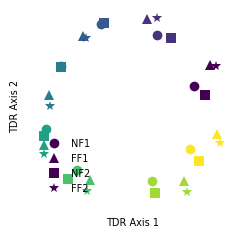

In [5]:
fig, ax = plot.plot_tdr(data_tdr[0],figsize=(2.5,2.5))
#fig.savefig(os.path.join(save_fig,'tdr.pdf'),dpi=300,bbox_inches='tight')

# Plot projection on uniform shift

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


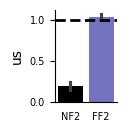

In [6]:
# Apply normalization
normalized_T,scale = normalize_phase_data(T)
normalized_T = normalized_T[normalized_T['phase'].isin(['NF2', 'FF2'])]

fig, ax = plot.my_barplot(normalized_T,x='phase',y='us',hue='phase',figsize=(0.8,1.2),width=0.8)
ax.axhline(1, color='black',linestyle='--',linewidth=2)
# fig.savefig(os.path.join(save_fig,'proj_on_us_0.pdf'),dpi=300,bbox_inches='tight')

In [14]:
from scipy.stats import ttest_rel, ttest_1samp

a = normalized_T[normalized_T['phase']=='NF2']['us'].values
t_stat, p_value = ttest_1samp(a,0)
print(f't-statistic: {t_stat}, p-value: {p_value}')

t-statistic: 7.484771313992047, p-value: 4.6715897222228e-09


# #2: Perturbation along and opposite uniform shift

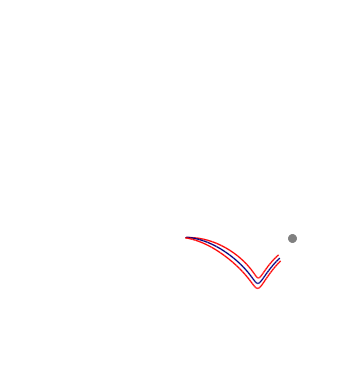

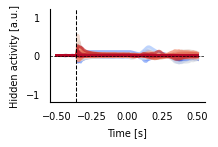

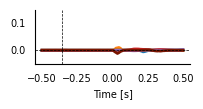

In [17]:
N_idx = 16 # 16 # time point just before the reach onset
F_idx = 59 # 25 # time point just after the reach onset
i = 0
ignore = return_ignore(folder_name,n_model)

models = [3]

for mn in models:
    model_name = 'model{:02d}'.format(mn)
    if mn in ignore:
        continue
    
    us_orth = US[mn]
    
    # perturb hidden
    data = []
    for mag in [2,0,-2]: # positive and negative perturbation
        d_hidden = th.from_numpy(mag*us_orth.T) # 0.6

        # now lets perturb or not and calculate the saving in behavior
        data_, = get_data(folder_name,model_name,{'NF2':[0]},[8],n_hidden=network_siz,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,catch_trial_perc=0) 
        data.append(data_)

    #1: plot trajectories
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    plot.plot_simulations(ax,xy=data[0]['xy'][i][None],target_xy=data[0]['tg'][i][None],cmap=ListedColormap(['red'],N=1),s=25,color_dot=np.array([0.5,0.5,0.5,1]))
    plot.plot_simulations(ax,xy=data[1]['xy'][i][None],target_xy=data[1]['tg'][i][None],cmap=ListedColormap(['navy'],N=1),s=25,color_dot=np.array([0.5,0.5,0.5,1]))
    plot.plot_simulations(ax,xy=data[2]['xy'][i][None],target_xy=data[2]['tg'][i][None],cmap=ListedColormap(['red'],N=1),s=25,color_dot=np.array([0.5,0.5,0.5,1]))

    #2: hidden
    hidden_0 = np.array(data[1]['all_hidden'][i,:,:])
    hidden_2 = np.array(data[0]['all_hidden'][i,:,:])
    x = np.linspace(0, np.shape(hidden_0)[0]*0.01, np.shape(hidden_0)[0])-0.5
    
    color_hidden1 = plt.cm.coolwarm(np.linspace(0, 1, hidden_0.shape[1]))
    #np.random.shuffle(color_hidden1)

    fg, ax = plot.my_plot(x,hidden_2-hidden_0,color_hidden1,(2,1.2),labels=None,ylim=[-1.2,1.2],plot0=True,ylabel='Hidden activity [a.u.]',alpha=0.75)
    ax.axvline(-0.36,color='k',linestyle='--',linewidth=0.75)
    #fg.savefig(os.path.join(save_fig,'delta_hidden.pdf'),dpi=300,bbox_inches='tight')



    #3: motor output
    output_0 = np.array(data[1]['all_action'][i,:,:])
    output_2 = np.array(data[0]['all_action'][i,:,:])

    color_output = np.ones((6,4))
    color_output[0,:3] = (31/255,119/255,180/255)
    color_output[1,:3] = (255/255,127/255,14/255)
    color_output[2,:3] = (44/255,160/255,44/255)
    color_output[3,:3] = (213/255,39/255,40/255)
    color_output[4,:3] = (148/255,103/255,189/255)
    color_output[5,:3] = (122/255,21/255,0/255)


    fg, ax = plot.my_plot(x,output_0-output_2,color_output,(2.,0.7),labels=None,ylim=[-0.05,0.15],plot0=True,ylabel='',linestyle=None)
    ax.axvline(-0.36, color='k',linestyle='--',linewidth=0.5)
    #fg.savefig(os.path.join(save_fig,'delta.pdf'),dpi=300,bbox_inches='tight')
